In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss
import os

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')
run_stats = {}

In [2]:
# parameters
dataset_name = ""
model_name = "resnet50_vicreg_ce"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM_species"
ood = "0:2:3"


In [4]:
# initialize data attributes and loaders
save_name = f"assets/results/{dataset_name}/{model_name}/{ood}"
os.makedirs(os.path.dirname(save_name + "_blank.file"), exist_ok=True)
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data(shuffle_training_data=False)
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 42153 images
Dataset type val label type: species


Loaded 5269 images
Dataset type test label type: species


 - Min class count:  976
Loaded 2928 images
Dataset type test label type: species


 - Min class count:  976
Loaded 17568 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

0:2:3 0qzdskm4


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-0qzdskm4:best, 314.55MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:8.0


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_ftr = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []

    val_inp = []
    val_ftr = []
    val_emb = []
    val_lgt = []
    val_tgt = []

    ind_inp = []
    ind_ftr = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_ftr = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_ftr.extend(ftr.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_ftr.extend(ftr.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_ftr.extend(ftr.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            ftr, emb, lgt = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_ftr.extend(ftr.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

  0%|                                                                                                                          | 0/330 [00:00<?, ?it/s]

  0%|▎                                                                                                                 | 1/330 [00:00<04:03,  1.35it/s]

  2%|██                                                                                                                | 6/330 [00:00<00:35,  9.02it/s]

  3%|███▊                                                                                                             | 11/330 [00:00<00:19, 16.49it/s]

  5%|█████▍                                                                                                           | 16/330 [00:01<00:13, 23.37it/s]

  6%|███████▏                                                                                                         | 21/330 [00:01<00:10, 29.39it/s]

  8%|████████▉                                                                                                        | 26/330 [00:01<00:08, 34.40it/s]

  9%|██████████▌                                                                                                      | 31/330 [00:01<00:07, 38.34it/s]

 11%|████████████▎                                                                                                    | 36/330 [00:01<00:07, 41.43it/s]

 12%|██████████████                                                                                                   | 41/330 [00:01<00:06, 43.78it/s]

 14%|████████████████                                                                                                 | 47/330 [00:01<00:06, 45.85it/s]

 16%|█████████████████▊                                                                                               | 52/330 [00:01<00:05, 46.94it/s]

 17%|███████████████████▌                                                                                             | 57/330 [00:01<00:05, 47.75it/s]

 19%|█████████████████████▌                                                                                           | 63/330 [00:02<00:05, 48.51it/s]

 21%|███████████████████████▎                                                                                         | 68/330 [00:02<00:05, 48.72it/s]

 22%|████████████████████████▉                                                                                        | 73/330 [00:02<00:05, 49.01it/s]

 24%|██████████████████████████▋                                                                                      | 78/330 [00:02<00:05, 49.24it/s]

 25%|████████████████████████████▊                                                                                    | 84/330 [00:02<00:04, 49.53it/s]

 27%|██████████████████████████████▊                                                                                  | 90/330 [00:02<00:04, 49.78it/s]

 29%|████████████████████████████████▊                                                                                | 96/330 [00:02<00:04, 49.82it/s]

 31%|██████████████████████████████████▎                                                                             | 101/330 [00:02<00:04, 49.76it/s]

 32%|███████████████████████████████████▉                                                                            | 106/330 [00:02<00:04, 49.81it/s]

 34%|█████████████████████████████████████▋                                                                          | 111/330 [00:02<00:04, 49.78it/s]

 35%|███████████████████████████████████████▎                                                                        | 116/330 [00:03<00:04, 49.83it/s]

 37%|█████████████████████████████████████████▍                                                                      | 122/330 [00:03<00:04, 49.97it/s]

 38%|███████████████████████████████████████████                                                                     | 127/330 [00:03<00:04, 49.92it/s]

 40%|████████████████████████████████████████████▊                                                                   | 132/330 [00:03<00:03, 49.85it/s]

 42%|██████████████████████████████████████████████▍                                                                 | 137/330 [00:03<00:03, 49.70it/s]

 43%|████████████████████████████████████████████████▏                                                               | 142/330 [00:03<00:03, 49.58it/s]

 45%|█████████████████████████████████████████████████▉                                                              | 147/330 [00:03<00:03, 49.70it/s]

 46%|███████████████████████████████████████████████████▌                                                            | 152/330 [00:03<00:03, 49.72it/s]

 48%|█████████████████████████████████████████████████████▎                                                          | 157/330 [00:03<00:03, 49.69it/s]

 49%|██████████████████████████████████████████████████████▉                                                         | 162/330 [00:03<00:03, 49.67it/s]

 51%|████████████████████████████████████████████████████████▋                                                       | 167/330 [00:04<00:03, 49.73it/s]

 52%|██████████████████████████████████████████████████████████▍                                                     | 172/330 [00:04<00:03, 49.72it/s]

 54%|████████████████████████████████████████████████████████████                                                    | 177/330 [00:04<00:03, 49.74it/s]

 55%|██████████████████████████████████████████████████████████████                                                  | 183/330 [00:04<00:02, 49.84it/s]

 57%|███████████████████████████████████████████████████████████████▊                                                | 188/330 [00:04<00:02, 49.79it/s]

 58%|█████████████████████████████████████████████████████████████████▌                                              | 193/330 [00:04<00:02, 49.74it/s]

 60%|███████████████████████████████████████████████████████████████████▏                                            | 198/330 [00:04<00:02, 49.70it/s]

 62%|████████████████████████████████████████████████████████████████████▉                                           | 203/330 [00:04<00:02, 49.75it/s]

 63%|██████████████████████████████████████████████████████████████████████▉                                         | 209/330 [00:04<00:02, 49.91it/s]

 65%|████████████████████████████████████████████████████████████████████████▋                                       | 214/330 [00:05<00:02, 49.90it/s]

 66%|██████████████████████████████████████████████████████████████████████████▎                                     | 219/330 [00:05<00:02, 49.90it/s]

 68%|████████████████████████████████████████████████████████████████████████████                                    | 224/330 [00:05<00:02, 49.91it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▋                                  | 229/330 [00:05<00:02, 49.73it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▍                                | 234/330 [00:05<00:01, 49.78it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████                               | 239/330 [00:05<00:01, 49.77it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████▏                            | 245/330 [00:05<00:01, 49.89it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▊                           | 250/330 [00:05<00:01, 49.88it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▌                         | 255/330 [00:05<00:01, 49.78it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▏                       | 260/330 [00:05<00:01, 49.76it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▎                     | 266/330 [00:06<00:01, 49.78it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▎                   | 272/330 [00:06<00:01, 49.90it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████                  | 277/330 [00:06<00:01, 49.92it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████▋                | 282/330 [00:06<00:00, 49.92it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████▍              | 287/330 [00:06<00:00, 49.89it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████             | 292/330 [00:06<00:00, 49.90it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 298/330 [00:06<00:00, 49.94it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 304/330 [00:06<00:00, 50.06it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 310/330 [00:06<00:00, 50.15it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 316/330 [00:07<00:00, 50.10it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 322/330 [00:07<00:00, 50.00it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 327/330 [00:07<00:00, 49.94it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 330/330 [00:07<00:00, 44.46it/s]

train - OK


  0%|                                                                                                                           | 0/42 [00:00<?, ?it/s]

  2%|██▋                                                                                                                | 1/42 [00:00<00:04,  8.94it/s]

 14%|████████████████▍                                                                                                  | 6/42 [00:00<00:01, 31.36it/s]

 26%|█████████████████████████████▊                                                                                    | 11/42 [00:00<00:00, 39.36it/s]

 38%|███████████████████████████████████████████▍                                                                      | 16/42 [00:00<00:00, 42.98it/s]

 50%|█████████████████████████████████████████████████████████                                                         | 21/42 [00:00<00:00, 44.82it/s]

 62%|██████████████████████████████████████████████████████████████████████▌                                           | 26/42 [00:00<00:00, 45.92it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████▏                             | 31/42 [00:00<00:00, 46.98it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                | 36/42 [00:00<00:00, 47.84it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 41/42 [00:00<00:00, 48.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 40.58it/s]

val - OK


  0%|                                                                                                                           | 0/23 [00:00<?, ?it/s]

  4%|█████                                                                                                              | 1/23 [00:00<00:02,  7.60it/s]

 26%|██████████████████████████████                                                                                     | 6/23 [00:00<00:00, 28.87it/s]

 48%|██████████████████████████████████████████████████████▌                                                           | 11/23 [00:00<00:00, 37.25it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▎                                  | 16/23 [00:00<00:00, 41.60it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████          | 21/23 [00:00<00:00, 44.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 34.98it/s]

test InD - OK


  0%|                                                                                                                          | 0/138 [00:00<?, ?it/s]

  1%|▊                                                                                                                 | 1/138 [00:00<00:18,  7.38it/s]

  4%|████▉                                                                                                             | 6/138 [00:00<00:04, 28.62it/s]

  8%|█████████                                                                                                        | 11/138 [00:00<00:03, 37.10it/s]

 12%|█████████████                                                                                                    | 16/138 [00:00<00:02, 41.47it/s]

 15%|█████████████████▏                                                                                               | 21/138 [00:00<00:02, 44.05it/s]

 19%|█████████████████████▎                                                                                           | 26/138 [00:00<00:02, 45.57it/s]

 22%|█████████████████████████▍                                                                                       | 31/138 [00:01<00:08, 12.52it/s]

 25%|████████████████████████████▋                                                                                    | 35/138 [00:01<00:06, 15.30it/s]

 29%|████████████████████████████████▊                                                                                | 40/138 [00:01<00:04, 19.82it/s]

 33%|████████████████████████████████████▊                                                                            | 45/138 [00:01<00:03, 24.53it/s]

 36%|████████████████████████████████████████▉                                                                        | 50/138 [00:02<00:03, 28.19it/s]

 40%|█████████████████████████████████████████████                                                                    | 55/138 [00:02<00:02, 32.41it/s]

 43%|█████████████████████████████████████████████████▏                                                               | 60/138 [00:02<00:02, 36.06it/s]

 47%|█████████████████████████████████████████████████████▏                                                           | 65/138 [00:02<00:01, 38.98it/s]

 51%|█████████████████████████████████████████████████████████▎                                                       | 70/138 [00:02<00:01, 41.43it/s]

 54%|█████████████████████████████████████████████████████████████▍                                                   | 75/138 [00:02<00:01, 43.26it/s]

 58%|█████████████████████████████████████████████████████████████████▌                                               | 80/138 [00:02<00:01, 44.66it/s]

 62%|█████████████████████████████████████████████████████████████████████▌                                           | 85/138 [00:02<00:01, 45.67it/s]

 65%|█████████████████████████████████████████████████████████████████████████▋                                       | 90/138 [00:02<00:01, 46.36it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▊                                   | 95/138 [00:02<00:00, 46.89it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████▏                              | 100/138 [00:03<00:00, 47.38it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▏                          | 105/138 [00:03<00:00, 47.77it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▎                      | 110/138 [00:03<00:00, 47.98it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▎                  | 115/138 [00:03<00:00, 48.10it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████▍              | 120/138 [00:03<00:00, 48.26it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 125/138 [00:03<00:00, 48.22it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 130/138 [00:03<00:00, 48.40it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 135/138 [00:03<00:00, 48.54it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:04<00:00, 32.09it/s]

test OoD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_ftr = np.array(trn_ftr).squeeze()
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)
np.savez_compressed(f"{save_name}_trn.npz", inp=trn_inp, ftr=trn_ftr, emb=trn_emb, lgt=trn_lgt, tgt=trn_tgt)

val_inp = np.array(val_inp)
val_ftr = np.array(val_ftr).squeeze()
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)
np.savez_compressed(f"{save_name}_val.npz", inp=val_inp, ftr=val_ftr, emb=val_emb, lgt=val_lgt, tgt=val_tgt)

ind_inp = np.array(ind_inp)
ind_ftr = np.array(ind_ftr).squeeze()
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)
np.savez_compressed(f"{save_name}_ind.npz", inp=ind_inp, ftr=ind_ftr, emb=ind_emb, lgt=ind_lgt, tgt=ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_ftr = np.array(ood_ftr).squeeze()
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)
    np.savez_compressed(f"{save_name}_ood.npz", inp=ood_inp, ftr=ood_ftr, emb=ood_emb, lgt=ood_lgt, tgt=ood_tgt)

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_ftr.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_ftr.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_ftr.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_ftr.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)

(42153, 3, 64, 64) (42153, 2048) (42153, 512) (42153, 2) (42153,)
(5269, 3, 64, 64) (5269, 2048) (5269, 512) (5269, 2) (5269,)
(2928, 3, 64, 64) (2928, 2048) (2928, 512) (2928, 2) (2928,)
(17568, 3, 64, 64) (17568, 2048) (17568, 512) (17568, 2) (17568,)


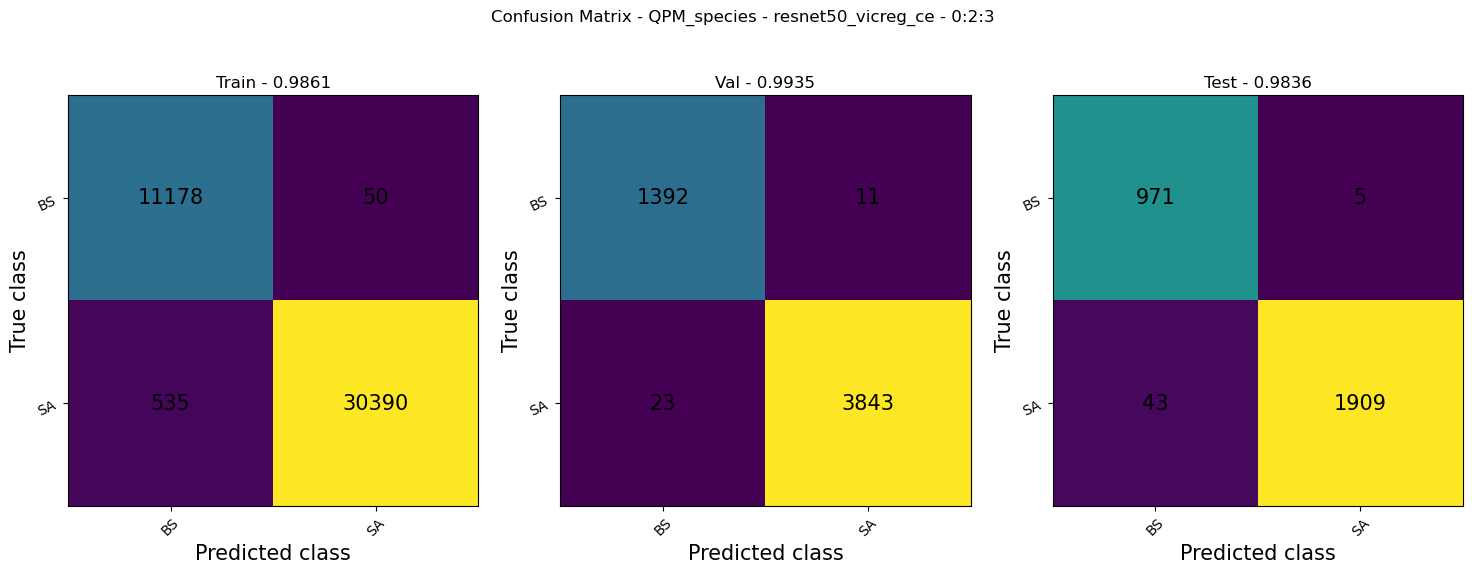

In [11]:
# compute test set accuracy
from torchmetrics import Accuracy, ConfusionMatrix

K = len(config.labels) - len(config.ood)
accuracy = Accuracy(task="multiclass", num_classes=K, top_k=1)

train_acc = accuracy(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt)).item()
accuracy.reset()
val_acc = accuracy(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt)).item()
accuracy.reset()
test_acc = accuracy(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt)).item()
run_stats.update(dict(train_acc=train_acc, val_acc=val_acc, test_acc=test_acc))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
confmat = ConfusionMatrix(task="multiclass", num_classes=K)
cm_trn = confmat(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax1)
ax1.set_title(f"Train - {train_acc:.4f}")
confmat.reset()
cm_val = confmat(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax2)
ax2.set_title(f"Val - {val_acc:.4f}")
confmat.reset()
cm_tst = confmat(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax3)
ax3.set_title(f"Test - {test_acc:.4f}")

plt.suptitle(f"Confusion Matrix - {dataset_name} - {model_name} - {ood_str}")
plt.show()

In [12]:
# create 2d embeddings
n = ind_ftr.shape[0]
all_ftr = ind_ftr
all_lgt = ind_lgt
if ood_str:
    all_ftr = np.concatenate([all_ftr, ood_ftr], axis=0)
    all_lgt = np.concatenate([all_lgt, ood_lgt], axis=0)

umap = UMAP(n_components=2, random_state=42)
all_ftr2d = umap.fit_transform(all_ftr)
ind_ftr2d = np.array(all_ftr2d[:n], order='C').astype(np.float32)
ood_ftr2d = np.array(all_ftr2d[n:], order='C').astype(np.float32)
print(ind_ftr2d.shape, ood_ftr2d.shape)

if all_lgt.shape[-1] > 2:
    umap = UMAP(n_components=2, random_state=42)
    lgt2d = umap.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

/n/home12/yasith/.conda/envs/robustml/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(2928, 2) (17568, 2)
(2928, 2) (17568, 2)


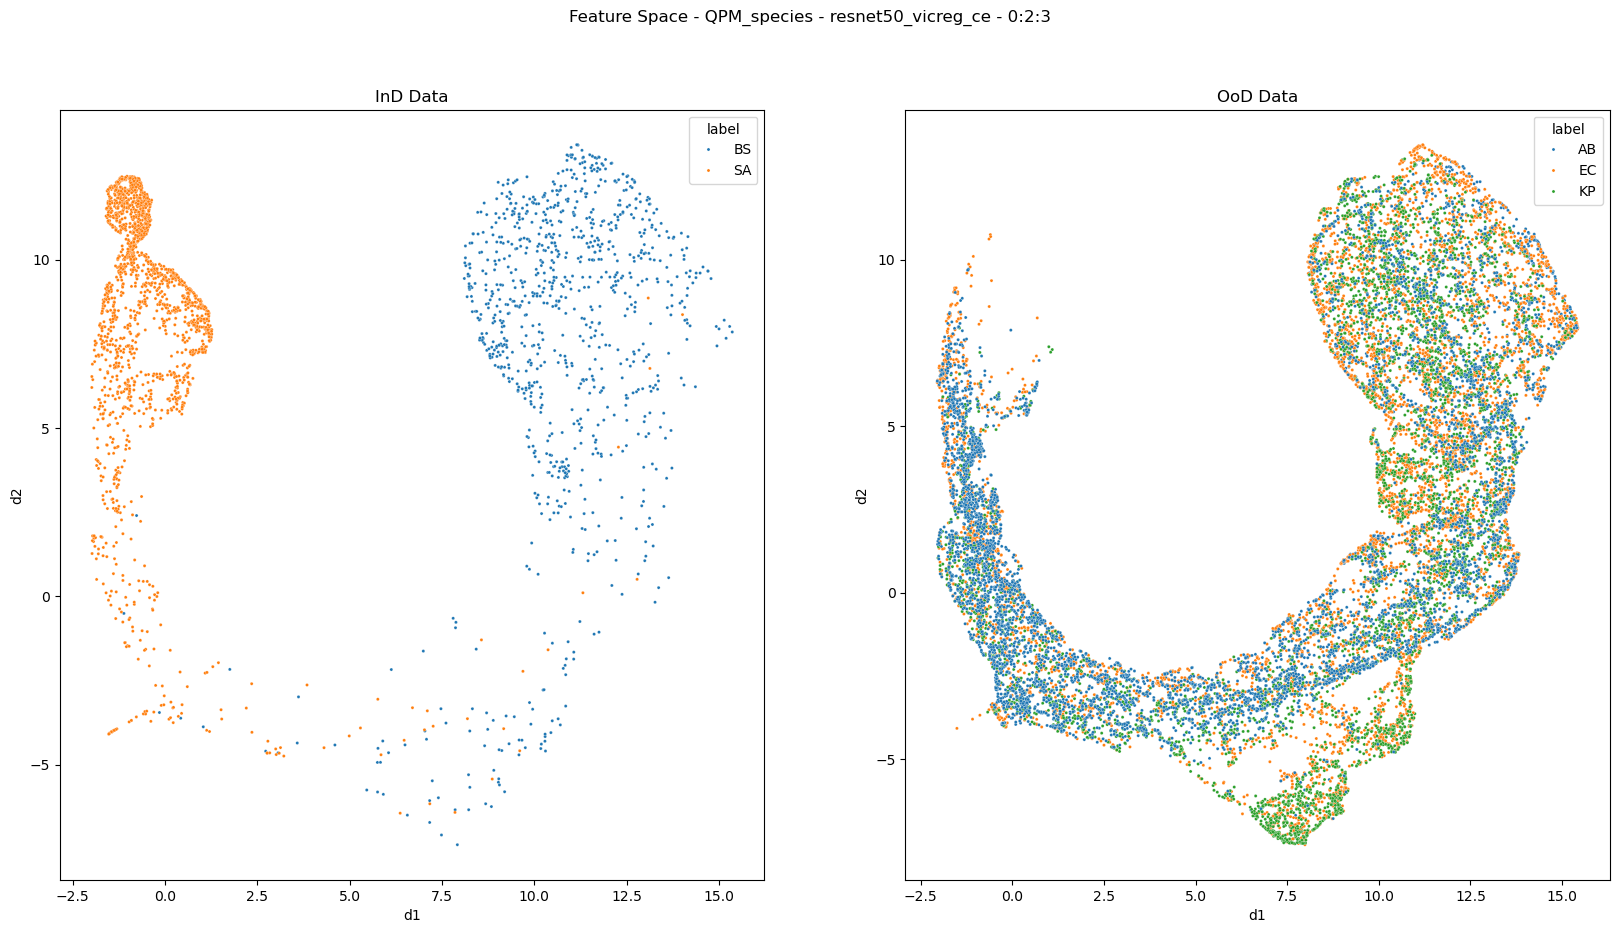

In [13]:
# plot feature space
df_ftr2d = pd.DataFrame()
d1, d2 = ind_ftr2d.T
df_ftr2d = pd.concat([df_ftr2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_ftr2d.T
    df_ftr2d = pd.concat([df_ftr2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_ftr2d[(df_ftr2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_ftr2d[(df_ftr2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

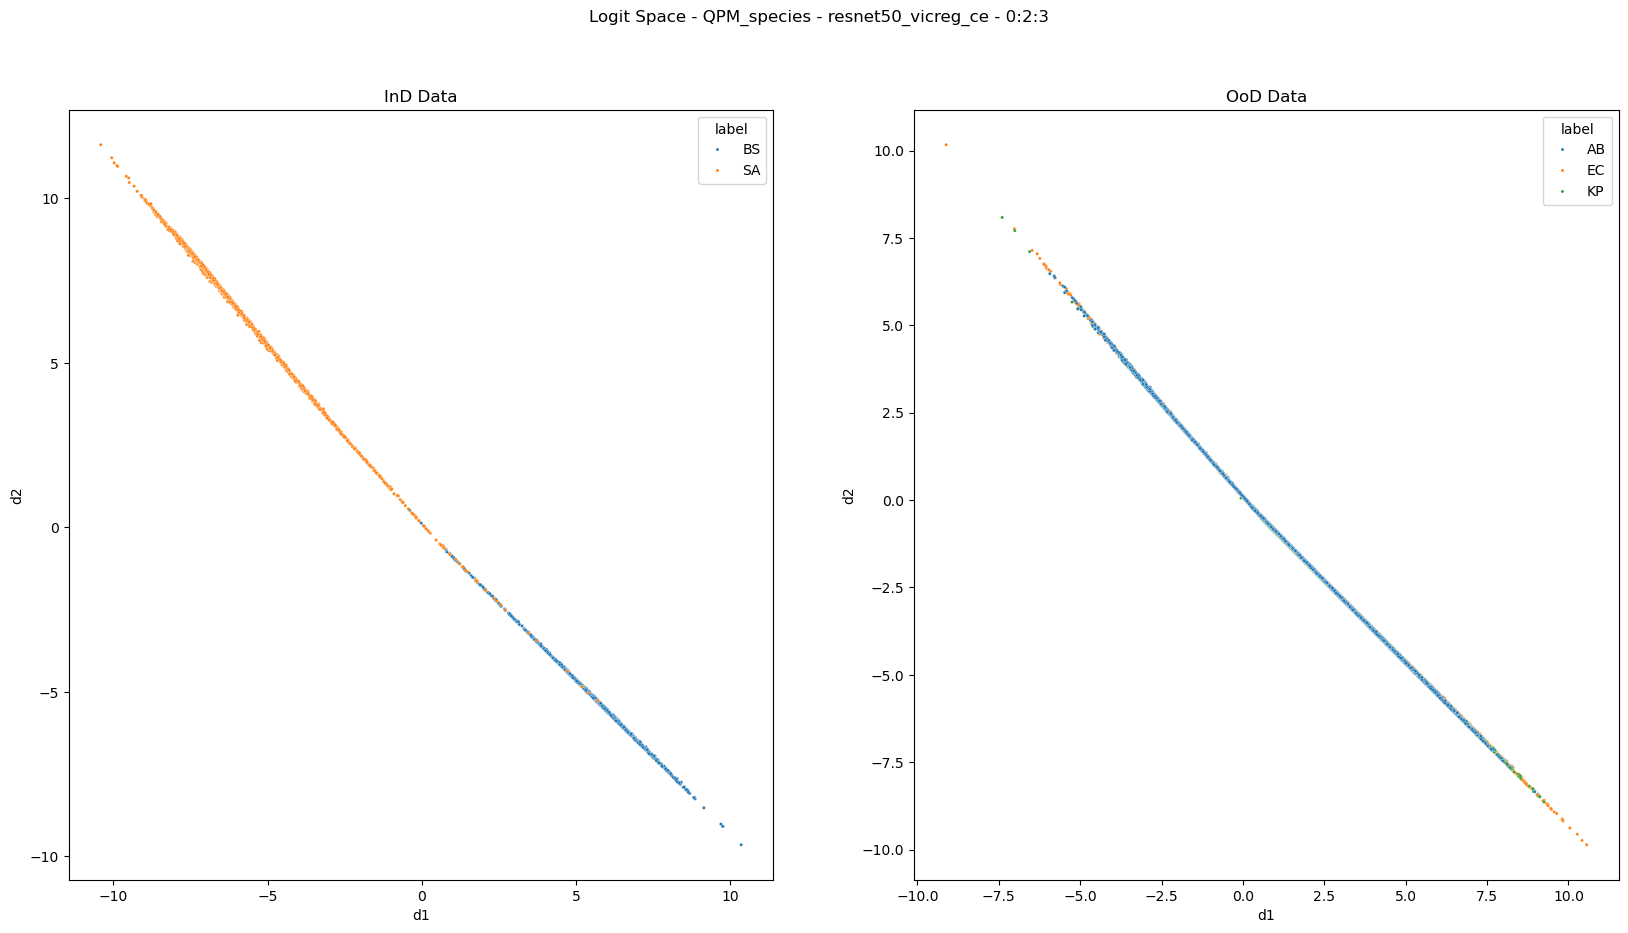

In [14]:
# plot logit space
df_lgt2d = pd.DataFrame()
d1, d2 = ind_lgt2d.T
df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

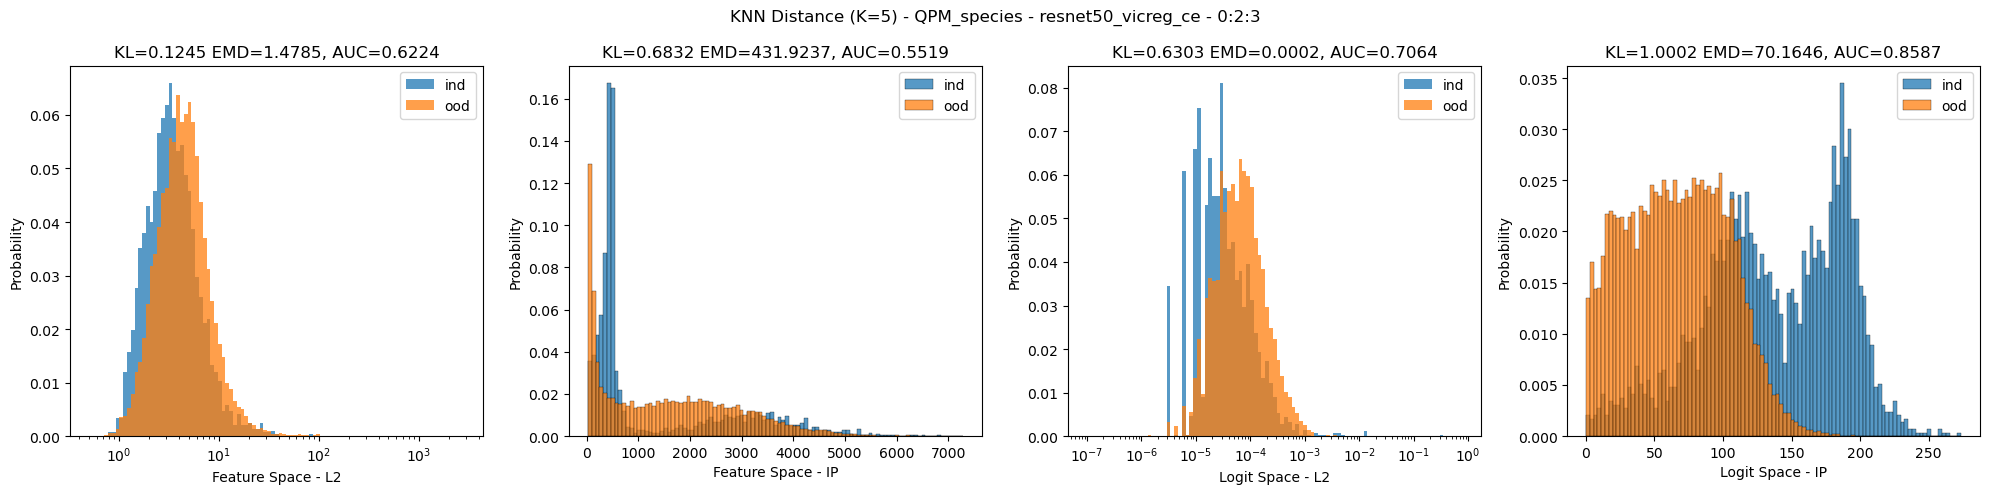

In [15]:
# plot knn distance from ind/ood to val data
def plot_knn_dists(index_fn, ax, trn_data, val_data, ind_data, ood_data=None, k=5, scale="linspace"):
    stats = {}
    index = index_fn(trn_data.shape[-1])
    index.add(trn_data)
    Dv = index.search(val_data, k)[0].mean(-1)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc, val_data=Dv.tolist(), ind_data=Di.tolist(), ood_data=Do.tolist()))
        
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()
    return stats

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")
run_stats["knn_f_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[0], trn_ftr, val_ftr, ind_ftr, ood_ftr if ood_str else None, scale="logspace")
axs[0].set_xlabel("Feature Space - L2")
run_stats["knn_f_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[1], trn_ftr, val_ftr, ind_ftr, ood_ftr if ood_str else None, scale="linspace")
axs[1].set_xlabel("Feature Space - IP")
run_stats["knn_l_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[2], trn_lgt, val_lgt, ind_lgt, ood_lgt if ood_str else None, scale="logspace")
axs[2].set_xlabel("Logit Space - L2")
run_stats["knn_l_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[3], trn_lgt, val_lgt, ind_lgt, ood_lgt if ood_str else None, scale="linspace")
axs[3].set_xlabel("Logit Space - IP")
plt.tight_layout()
plt.show()

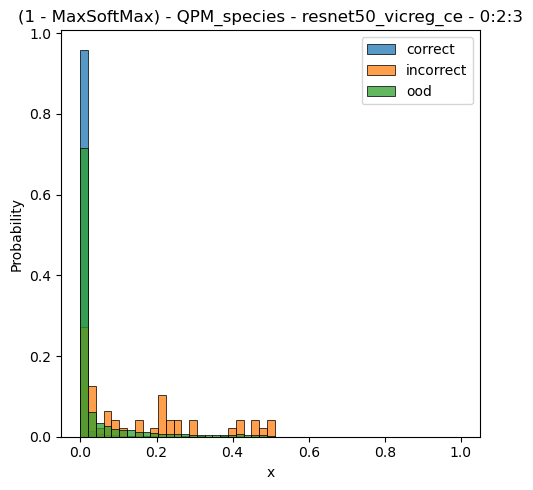

In [16]:
# plot (1 - maxsoftmax) of correct-ind, incorrect-ind, and ood data
ind_prob = np.exp(ind_lgt.astype(np.float64)) / np.exp(ind_lgt.astype(np.float64)).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt.astype(np.float64)) / np.exp(ood_lgt.astype(np.float64)).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

In [17]:
run_stats.update(dict(dataset_name=dataset_name, model_name=model_name, ood=ood))
import gzip
import pickle
with gzip.open(f"{save_name}_stats.gz", "wb") as f:
    pickle.dump(run_stats, f)